In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [3]:
# fpath = 'C:/Users/stell/data/'
fpath = 'E:/SNUH_EEG_data/EEG_data/'

x_stft = np.load(fpath + 'stft_x_tlen4_corrected.npy') # num_data, num_window, num_freqs, num_time, num_ch (2188, 25, 251, 9, 21)
x = np.load(fpath + 'x_correct.npy') # num_data, num_ch, num_time_points (2188, 21, 50000)
y = np.load(fpath + 'y_correct.npy') # num_data, symptoms (2188, 17)

print(x_stft.shape)
print(x.shape)
print(y.shape)

(2188, 25, 251, 9, 21)
(2188, 21, 50000)
(2188, 17)


In [4]:
fs = 500
t_len = 4
total_t_len = 100
num_win = int(total_t_len/t_len) # 25

fft_win_time = 1
n_fft = fft_win_time * fs # 500
fft_overlap_time = fft_win_time/2*fs
freqs = torch.fft.rfftfreq(n_fft, 1 / fs)

print(x_stft[0][0][0][0]) # 21 channel 당 값
print(x_stft[0][0][0][0][0]) # 한 채널 당 값

[ -48.805756+0.j  128.58377 +0.j  125.954605+0.j  -28.771269+0.j
 -111.53321 +0.j   72.64079 +0.j   81.4202  +0.j  -28.337587+0.j
    8.03219 +0.j  167.07208 +0.j  415.81134 +0.j  171.02844 +0.j
 -309.4283  +0.j -369.30115 +0.j  -68.63318 +0.j -200.64812 +0.j
 -121.940384+0.j  -82.856445+0.j  178.7245  +0.j -190.2455  +0.j
   77.22679 +0.j]
(-48.805756+0j)


###### total time 100 sec를 4 sec씩 자름 -> num_window = 25개
###### 4 sec를 1 sec win_time씩 fft (overlap_time = 1/2 sec) -> 9번 fft -> stft 결과물 num_time_window =9, num_freqs_window =251

In [6]:
print(y[0])
# min-max normalization
print(np.min(y))
print(np.max(y))
y = (y - np.min(y)) / (np.max(y) - np.min(y))
print(y[0])

[0.33333333 0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
0.0
1.0
[0.33333333 0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
-99.71658325195312
99.81100463867188


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, 
                                                        test_size=0.2, random_state=100)

num_batch, num_ch, num_time_points = X_train.shape
X_train = torch.reshape(torch.tensor(X_train), (num_batch, num_ch, num_win, 2000))  # B x C x window x T         [1750, 21, 25, 2000]
X_train = X_train.permute(0, 2, 1, 3)   # B x window x C x T
X_train = torch.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2], X_train.shape[3]))   # B*window x C x T         [438*25, 21, 2000]
Y_train = torch.tensor(Y_train)

num_batch, num_ch, num_time_points = X_test.shape
X_test = torch.reshape(torch.tensor(X_test), (num_batch, num_ch, num_win, 2000))    # B x C x window x T         [438, 21, 25, 2000]
X_test = X_test.permute(0, 2, 1, 3)     # B x window x C x T
X_test = torch.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2], X_test.shape[3])) # B*window x C x T         [438*25, 21, 2000]
Y_test = torch.tensor(Y_test)

In [8]:
print(X_train.shape)    # B*window x C x T         [43750, 21, 2000]
print(Y_train.shape)    # B x C x symptom          [1750, 17]
print(X_test.shape)     # B*window x C x T         [10950, 21, 2000]
print(Y_test.shape)     # B x C x symptom          [438, 17]

torch.Size([43750, 21, 2000])
torch.Size([1750, 17])
torch.Size([10950, 21, 2000])
torch.Size([438, 17])


In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, final=False):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding='same')
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, dilation=dilation, padding='same')
        self.projector = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels or final else None

    def forward(self, x):
        residual = x if self.projector is None else self.projector(x)
        x = F.gelu(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        return x + residual
    
class simpleCNN2d(nn.Module):
    def __init__(self, in_dims, hidden_dims, out_dims, num_time, kernel_size, num_layers):
        super().__init__()

        self.fc1 = nn.Linear(in_dims, hidden_dims)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        channels = [hidden_dims] * (num_layers + 1)

        self.net = nn.Sequential(*[
            ConvBlock(
                channels[i-1] if i > 0 else hidden_dims,
                channels[i],
                kernel_size=kernel_size,
                dilation=1,
                final=(i == len(channels)-1)
            )
            for i in range(len(channels)) # layer 수 만큼
        ])
        
        self.squeeze_ch = nn.Conv1d(hidden_dims, 1, 1)

        self.fc2 = nn.Linear(num_time, out_dims)

    def forward(self, x): # x: B x C x T
        x = self.gelu(self.dropout(self.fc1(x.permute(0, 2, 1)))) # x: B x T x C
        x = x.permute(0, 2, 1) # x: B x C x T
        x = self.net(x) # x: B x C x T
        x = self.gelu(self.squeeze_ch(x)).squeeze(1) # x: B x 1 x T -> B x T
        x = self.fc2(x) # x: B x out_dims
        x = self.relu(x) # x: B x out_dims
        return x

In [10]:
cycle_l1_loss = nn.L1Loss(reduction='sum')

In [11]:
X_train.shape

torch.Size([43750, 21, 2000])

In [12]:
x.shape

(2188, 21, 50000)

In [24]:
num_freqs = freqs.shape[0]
batch_size = 16
num_epochs = 100
in_dims = 21
hidden_dims = 128
out_dims = 17
kernel_size = 3
num_layers = 10
num_time = X_train.shape[2]
lr = 1e-4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = list(zip(X_train, Y_train))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = simpleCNN2d(in_dims, hidden_dims, out_dims, num_time, kernel_size, num_layers).to(device)
        
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch[0] # x: B x C x T
        B_size, C_size, T_size = x.shape
        x = x.type(torch.float32)
        x = x.to(device)

        y = batch[1] # y: B x out_dims
        y = y.type(torch.float32)
        y = y.to(device)
                
        y_hat = model(x)
        
        loss = cycle_l1_loss(y_hat, y)
        loss.backward()
        optimizer.step()

    print('Epoch: [{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss.item()))

Epoch: [1/100], loss: 10.124575
Epoch: [2/100], loss: 17.579170
Epoch: [3/100], loss: 13.471107
Epoch: [4/100], loss: 15.502775
Epoch: [5/100], loss: 13.268649
Epoch: [6/100], loss: 13.659594
Epoch: [7/100], loss: 23.256443
Epoch: [8/100], loss: 15.688007
Epoch: [9/100], loss: 20.979416
Epoch: [10/100], loss: 14.138585
Epoch: [11/100], loss: 12.452477
Epoch: [12/100], loss: 17.132711
Epoch: [13/100], loss: 14.586010
Epoch: [14/100], loss: 14.926784
Epoch: [15/100], loss: 14.095595
Epoch: [16/100], loss: 10.458994
Epoch: [17/100], loss: 15.330668
Epoch: [18/100], loss: 12.626156
Epoch: [19/100], loss: 17.314339
Epoch: [20/100], loss: 14.735289
Epoch: [21/100], loss: 12.622069
Epoch: [22/100], loss: 12.063026
Epoch: [23/100], loss: 15.162788
Epoch: [24/100], loss: 11.093580
Epoch: [25/100], loss: 9.624737
Epoch: [26/100], loss: 12.876577
Epoch: [27/100], loss: 12.530445
Epoch: [28/100], loss: 14.542026
Epoch: [29/100], loss: 14.163343
Epoch: [30/100], loss: 10.852467
Epoch: [31/100], los

In [25]:
torch.save(model.state_dict(), './model.pth')

In [26]:
dataset = list(zip(X_test, Y_test))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

inputs_x = torch.tensor([])
inputs_y = torch.tensor([])
outputs_y_hat = torch.tensor([])

with torch.no_grad():
    for batch in dataloader:
        x = batch[0] # x: B x C x T
        B_size, C_size, T_size = x.shape
        x = x.type(torch.float32)
        x = x.to(device)

        y = batch[1] # y: B x out_dims
        y = y.type(torch.float32)
        y = y.to(device)
                
        y_hat = model(x)

        inputs_x = torch.cat((inputs_x, x.cpu()), 0)
        inputs_y = torch.cat((inputs_y, y.cpu()), 0)
        outputs_y_hat = torch.cat((outputs_y_hat, y_hat.cpu()), 0)

In [27]:
err = torch.abs(outputs_y_hat - inputs_y)

In [28]:
torch.argmin(err)

tensor(2)

In [29]:
err

tensor([[1.1185, 0.3790, 0.0000,  ..., 0.2577, 0.0000, 0.0000],
        [1.0000, 0.4406, 0.1586,  ..., 0.3234, 0.0000, 0.0000],
        [0.2321, 0.1766, 0.0000,  ..., 0.0000, 0.0536, 0.0000],
        ...,
        [0.6667, 0.4298, 0.0000,  ..., 0.2575, 0.0000, 0.0000],
        [0.3957, 0.7388, 0.0000,  ..., 0.6667, 0.0000, 0.0000],
        [0.3862, 0.6424, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [30]:
print(torch.mean(err))

tensor(0.1512)


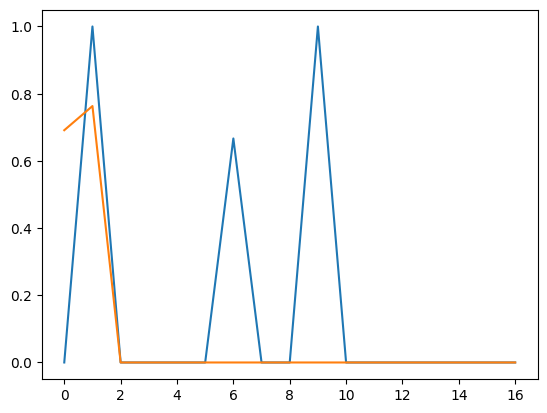

In [42]:
data_idx = 432
plt.plot(inputs_y[data_idx, :].detach().numpy())
plt.plot(outputs_y_hat[data_idx, :].detach().numpy())